# About

These is a base solution of PID.

In [1]:
%matplotlib inline
import random
import pandas
import numpy
import cPickle as pickle
import matplotlib.pyplot as plt

import root_numpy
from sklearn.metrics import roc_auc_score, roc_curve

from rep.estimators import TMVAClassifier, XGBoostClassifier

# Directories

In [8]:
track = 'Long'
particle = 'Electron'

data_path = "../../../data/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/\
GhostAccFrac1.0/TMVA-Run2-NoTkLikCD/Long"

work_path = "baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/" + \
"multiclass/Long/XGBoost"

netconfig_path = "../../../data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/" + "GlobalPID_" \
+ particle + "_Long_ANN.txt"

# Read data

In [9]:
particle_pdg_codes = {"all": 999999,
                    "Ghost": 0,
                    "Electron": 11,
                    "Muon": 13,
                    "Pion": 211,
                    "Kaon": 321,
                    "Proton": 2212}

particles = ["Ghost", "Electron", "Muon", "Pion", "Kaon", "Proton"]
labs = [0, 1, 2, 3, 4, 5]

In [10]:
data = pandas.read_csv(data_path + "/data_train.csv")

# Features

In [11]:
def get_features(netconfig_path):
    
    netconfig = numpy.loadtxt(netconfig_path, dtype='S', delimiter='\n', comments='!')
    features = []
    spectator_features = []

    for var in netconfig[5:]:

        if var.find('#') == -1:
            features.append(var)
        else:
            spectator_features.append(var[1:])
            
    return features

In [12]:
features_all = []

for one_particle in particles:
    
    netconfig_path = "../../../data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/" + "GlobalPID_" \
    + one_particle + "_Long_ANN.txt"

    features_all += get_features(netconfig_path)

In [13]:
features = numpy.unique(features_all)
features

array(['BremPIDe', 'CaloPrsE', 'EcalPIDe', 'EcalPIDmu', 'HcalPIDe',
       'HcalPIDmu', 'InAccBrem', 'InAccEcal', 'InAccHcal', 'InAccMuon',
       'InAccPrs', 'MuonBkgLL', 'MuonIsLooseMuon', 'MuonIsMuon',
       'MuonMuLL', 'MuonNShared', 'PrsPIDe', 'RichAboveKaThres',
       'RichAboveMuThres', 'RichAbovePiThres', 'RichAbovePrThres',
       'RichDLLbt', 'RichDLLe', 'RichDLLk', 'RichDLLmu', 'RichDLLp',
       'RichUsedR1Gas', 'RichUsedR2Gas', 'TrackChi2PerDof',
       'TrackFitMatchChi2', 'TrackFitTChi2', 'TrackFitTNDoF',
       'TrackFitVeloChi2', 'TrackFitVeloNDoF', 'TrackGhostProbability',
       'TrackNumDof', 'TrackP', 'TrackPt'], 
      dtype='|S21')

# Train XGBoost

In [28]:
mc_p_type = numpy.abs(data.MCParticleType.values)
labels = numpy.zeros(len(mc_p_type))

for one_particle, one_lab in zip(particles, labs):
    
    pdg = particle_pdg_codes[one_particle]
    labels += one_lab * (mc_p_type == pdg)
    
numpy.unique(labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.])

In [29]:
weights = numpy.zeros(len(labels))

for one_lab in labs:
    
    weights += 0.01 * (labels == one_lab) * len(labels) / ((labels == one_lab).sum())
    
numpy.unique(weights)

array([ 0.01549947,  0.07053886,  0.08679237,  0.14642896,  0.40215825,
        2.13903743])

In [30]:
from sklearn.cross_validation import train_test_split

train_inds, test_inds, labels_train, labels_test, weights_train, weights_test = train_test_split(data.index, 
                                                                                                 labels, 
                                                                                                 weights, 
                                                                                                 test_size=0.25, 
                                                                                                 random_state=42)

In [31]:
%%time
clf = XGBoostClassifier(n_estimators=1000, 
                        colsample=0.7, 
                        eta=0.01, 
                        nthreads=4, 
                        subsample=0.5, 
                        max_depth=8,
                        min_child_weight = 100,
                        features=features)

clf.fit(data.loc[train_inds], labels_train, sample_weight=weights_train)

CPU times: user 15h 45min 42s, sys: 28.7 s, total: 15h 46min 11s
Wall time: 4h 21min 43s


# Save the classifier

In [32]:
params = clf.get_params()
params_str = ""
for key, val in zip(params.keys(), params.values()):
    if key != "features":
        params_str += key + "=" + str(val) + ";"

In [33]:
new_work_path = work_path + "/" + params_str
new_work_path

'baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/multiclass/Long/XGBoost/verbose=0;missing=-999.0;scale_pos_weight=1.0;random_state=0;num_feature=None;base_score=0.5;n_estimators=1000;subsample=0.5;eta=0.01;min_child_weight=100;colsample=0.7;max_depth=8;gamma=None;nthreads=4;'

In [34]:
# Save classifier
import os
if not os.path.exists(new_work_path):
    os.makedirs(new_work_path)

# clf_pickle = open(new_work_path + '/classifier.pkl', 'wb')
# pickle.dump(clf, clf_pickle)
# clf_pickle.close()

In [7]:
#new_work_path = "baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/multiclass/Long/XGBoost/verbose=0;missing=-999.0;scale_pos_weight=1.0;random_state=0;num_feature=None;base_score=0.5;n_estimators=1000;subsample=0.5;eta=0.01;min_child_weight=1.0;colsample=0.7;max_depth=8;gamma=None;nthreads=3;"

In [8]:
# Read classifier
clf_pickle2 = open(new_work_path + '/classifier.pkl', 'rb')
clf2 = pickle.load(clf_pickle2)
clf_pickle2.close()

# Test the classifier

In [35]:
probas = clf.predict_proba(data.loc[test_inds])

In [36]:
probas[:5, :]

array([[  2.62566842e-02,   4.47872007e-04,   2.60399329e-03,
          9.67501879e-01,   1.68709003e-03,   1.50248350e-03],
       [  1.12255448e-02,   1.26310950e-03,   3.27402051e-03,
          5.59824519e-02,   5.03178120e-01,   4.25076783e-01],
       [  1.55307893e-02,   2.91220873e-04,   1.88203680e-03,
          9.80515599e-01,   1.00090436e-03,   7.79409951e-04],
       [  6.60598427e-02,   8.00022364e-01,   2.03780960e-02,
          7.42517039e-02,   2.40580644e-02,   1.52299656e-02],
       [  3.98175120e-01,   2.89928704e-03,   5.89793809e-02,
          5.29470563e-01,   5.28867496e-03,   5.18696615e-03]], dtype=float32)

In [37]:
particles = ["Ghost", "Electron", "Muon", "Pion", "Kaon", "Proton"]
colors = ['k', 'r', 'g', 'b', 'gold', 'm']

def get_roc_curves(probas, labels, particles, colors, labs):

    plt.figure(figsize=(10,7))

    for num in range(0, len(particles)):
        
        one_particle = particles[num]
        one_color = colors[num]
        one_lab = labs[num]

        one_labels = (labels == one_lab)*1
        one_probas = probas[:, num]
        roc_auc = roc_auc_score(one_labels, one_probas)
        fpr, tpr, _ = roc_curve(one_labels, one_probas)
        plt.plot(fpr, tpr, label=one_particle + ', %.2f' % roc_auc, color=one_color, linewidth=2)

    plt.title("ROC AUC", size=15)
    plt.xlabel("FPR", size=15)
    plt.ylabel("TPR", size=15)
    plt.legend(loc='best',prop={'size':15})
    plt.xticks(numpy.arange(0, 1.01, 0.1), size=15)
    plt.yticks(numpy.arange(0, 1.01, 0.1), size=15)
    plt.show()

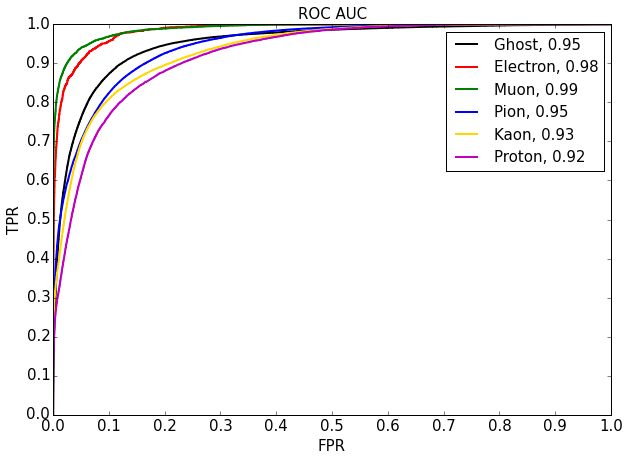

In [38]:
get_roc_curves(probas, labels_test, particles, colors, labs)

# Evaluation

In [9]:
data_eval = pandas.read_csv(data_path + "/data_eval.csv")

In [10]:
mc_p_type_eval = numpy.abs(data_eval.MCParticleType.values)
labels_eval = numpy.zeros(len(mc_p_type_eval))

for one_particle, one_lab in zip(particles, labs):
    
    pdg = particle_pdg_codes[one_particle]
    labels_eval += one_lab * (mc_p_type_eval == pdg)
    
numpy.unique(labels_eval)

array([ 0.,  1.,  2.,  3.,  4.,  5.])

In [11]:
import os, sys
sys.path.append('src')

from get_figures import all_figures

In [12]:
proba_eval = clf2.predict_proba(data_eval)

In [15]:
#numpy.savetxt('xgboost_proba_eval.csv', proba_eval)

In [20]:
#proba_eval = numpy.loadtxt('xgboost_proba_eval.csv')

In [18]:
proba_eval[:5, :]

array([[  5.92528377e-03,   7.38939270e-04,   2.78883167e-02,
          8.46206099e-02,   1.73899308e-01,   7.06927538e-01],
       [  6.75568264e-03,   6.61364931e-04,   2.43331473e-02,
          2.67903134e-03,   7.43510723e-01,   2.22060055e-01],
       [  8.95921979e-03,   6.22549735e-04,   3.21224965e-02,
          9.51440692e-01,   4.69715241e-03,   2.15787929e-03],
       [  8.55420679e-02,   4.13950579e-03,   1.51069671e-01,
          7.19965935e-01,   2.71851737e-02,   1.20976679e-02],
       [  3.72011936e-03,   3.64876061e-04,   2.27756221e-02,
          9.72052276e-01,   7.01095734e-04,   3.86001513e-04]], dtype=float32)

In [19]:
for num in range(0, len(particles)):
        
    one_particle = particles[num]
    one_lab = labs[num]

    one_labels = (labels_eval == one_lab)*1
    one_probas = numpy.concatenate((1.-proba_eval[:, num].reshape(-1,1), proba_eval[:, num].reshape(-1,1)),axis=1)
    
    params = {}
    params['PARTICLE'] = one_particle
    params['TRACK'] = 'Long'
    
    all_figures(params, data_eval, one_probas, one_labels, features, path= new_work_path + "/"+ one_particle +"/pic")